# Understanding 4F Optical Systems

In [8]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.PlaneWave import PlaneWave
from Props.AngularSpectrum import ASMPropagator as ASM_prop
from utils.units import *
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from utils.Helper_Functions import normalize

In [9]:
# System parameter setting
height, width = 1024, 1024
spacing = 6.4 * um
wvl = 633 * nm
f = 0.1 * m
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# load image as the input field
im = np.array(Image.open('./cameraman.png').convert('L'))
im = torch.tensor(im, dtype=torch.float).unsqueeze(0).unsqueeze(0)
im = normalize(im)
im = nn.functional.interpolate(im, size=[height, width])

in_field = im * torch.exp(0.1j * torch.randn(1, 1, height, width)) # add radom phase 

# Cast into our Datatype
field_input = ElectricField(
    data=in_field, 
    wavelengths=wvl,
    spacing=spacing,
)

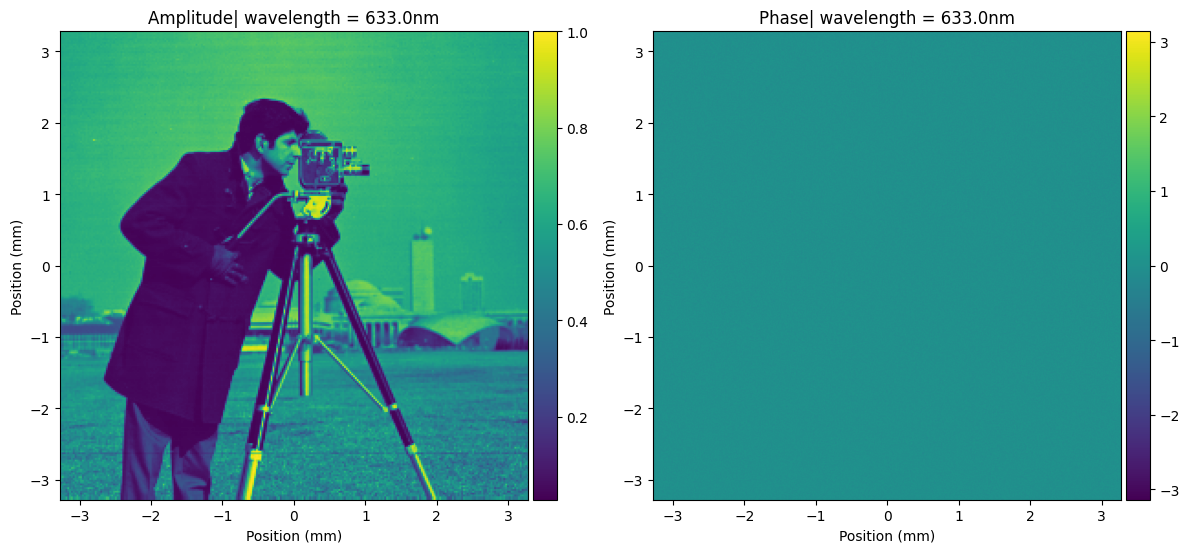

In [10]:
field_input.visualize(figsize=(12, 12), wavelength=wvl, flag_axis=True, intensity=False)

## Implement the 4F system with frequency filtering

### 1. Create different frequency filters

In [11]:
def create_filters(height, width, radius_ratios=[0.10, 0.05, 0.06, 0.03], 
                   filter_types=['low', 'low', 'high', 'high']):
    
    center_y, center_x = height//2, width//2
    y, x = np.ogrid[-center_y:height-center_y, -center_x:width-center_x]
    r = np.sqrt(x*x + y*y)
    
    # Create frequency filters
    masks = []
    for i in range(len(radius_ratios)):
        inner_radius = min(center_y, center_x) * radius_ratios[i]
        mask = r < inner_radius if filter_types[i] == 'low' else r > inner_radius
        mask = torch.tensor(mask, device=device).float()
        masks.append(mask)
    
    return masks

In [12]:
asm_prop = ASM_prop(z_distance=f, 
                    bandlimit_type='exact', 
                    padding_scale=[2, 2], 
                    bandlimit_kernel=True)

lens1 = Thin_LensElement(focal_length=f)

lens2 = Thin_LensElement(focal_length=f)

In [13]:
def apply_4F_system(in_field, lens1, lens2, filter_aperture):
    # propagate the first f distance
    field = asm_prop(in_field)
    # pass through first lens
    field = lens1(field)
    # propagate the second f distance
    field = asm_prop(field)
    # Visualize at Fourier plane
    field.visualize(figsize=(12, 12), wavelength=wvl, flag_axis=True, intensity=False)
    # Apply frequency filter
    field.data = field.data * filter_aperture
    #field.visualize(figsize=(12, 12), wavelength=wvl, flag_axis=True, intensity=False)
    # Propagate third F distance
    field = asm_prop(field)
    # Pass through second lens
    field = lens2(field)
    # Propagate forth F distance
    field = asm_prop(field)

    return field

The critical distance is 198.53894412517548 mm, the TF will be fine during the sampling !


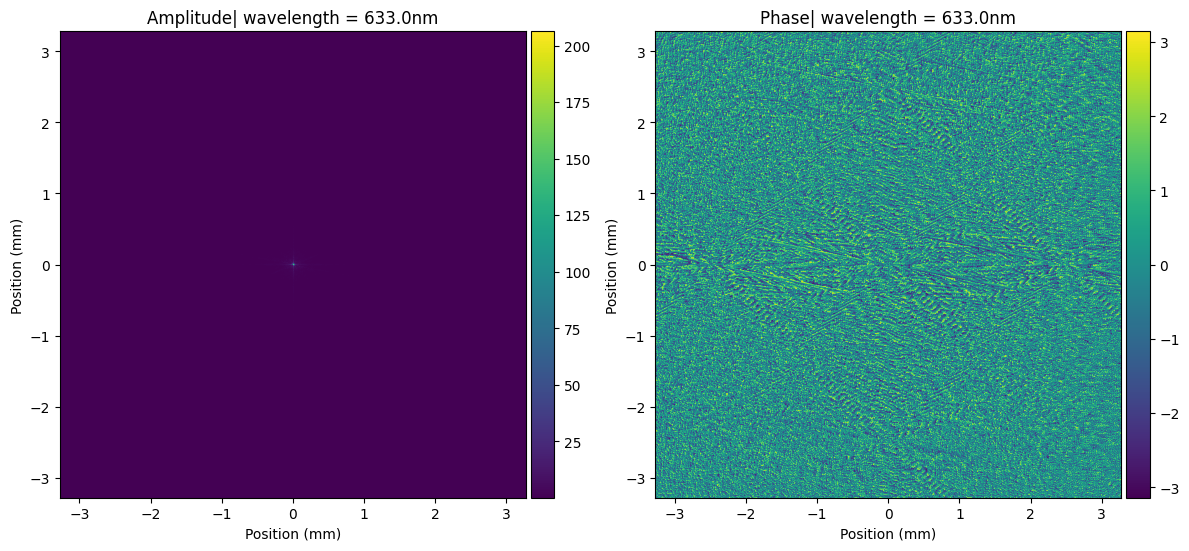

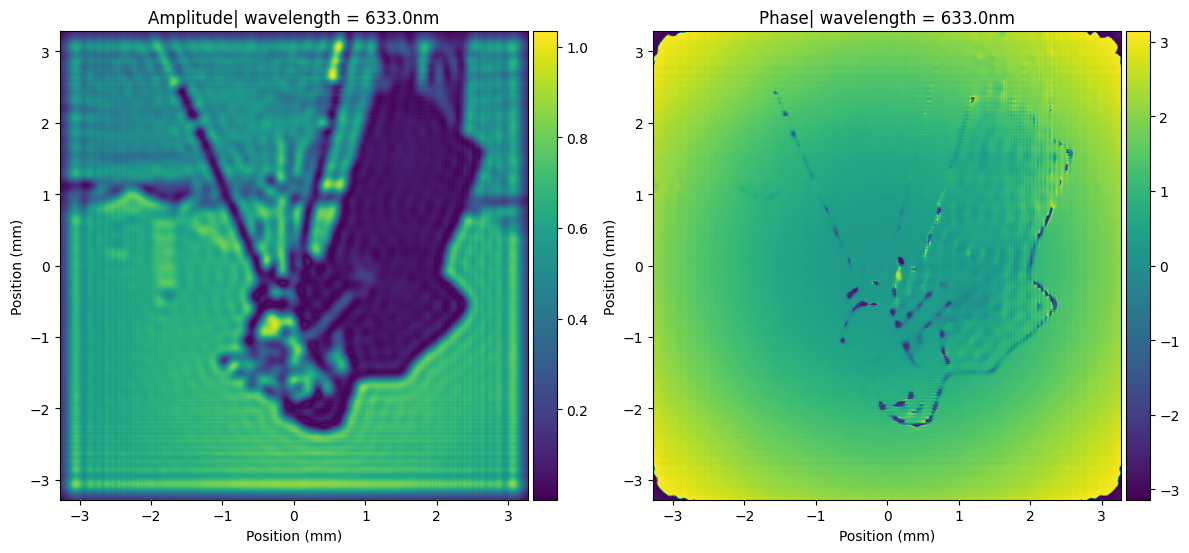

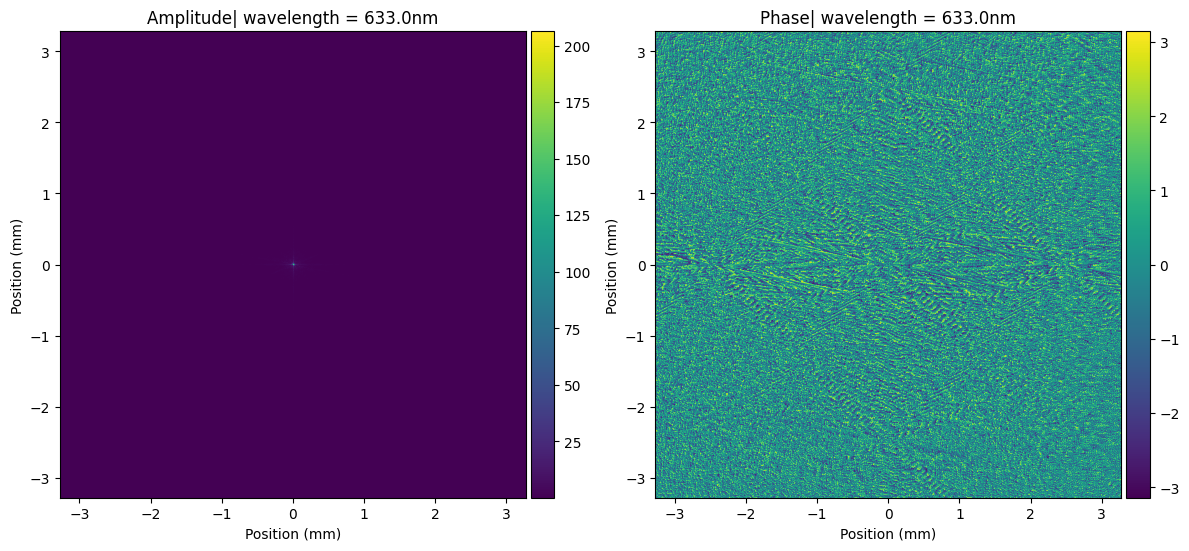

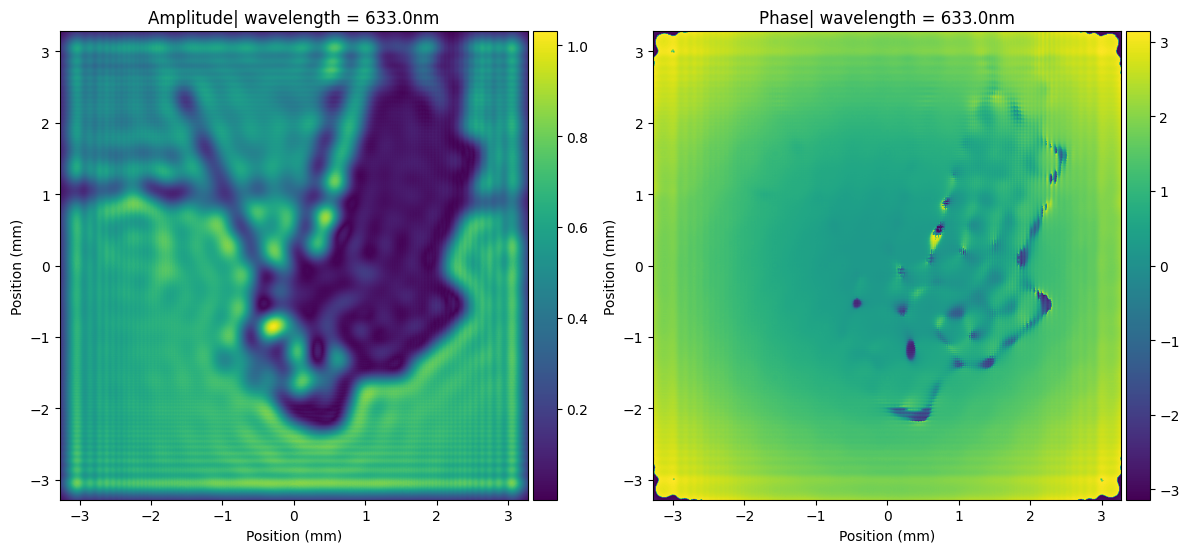

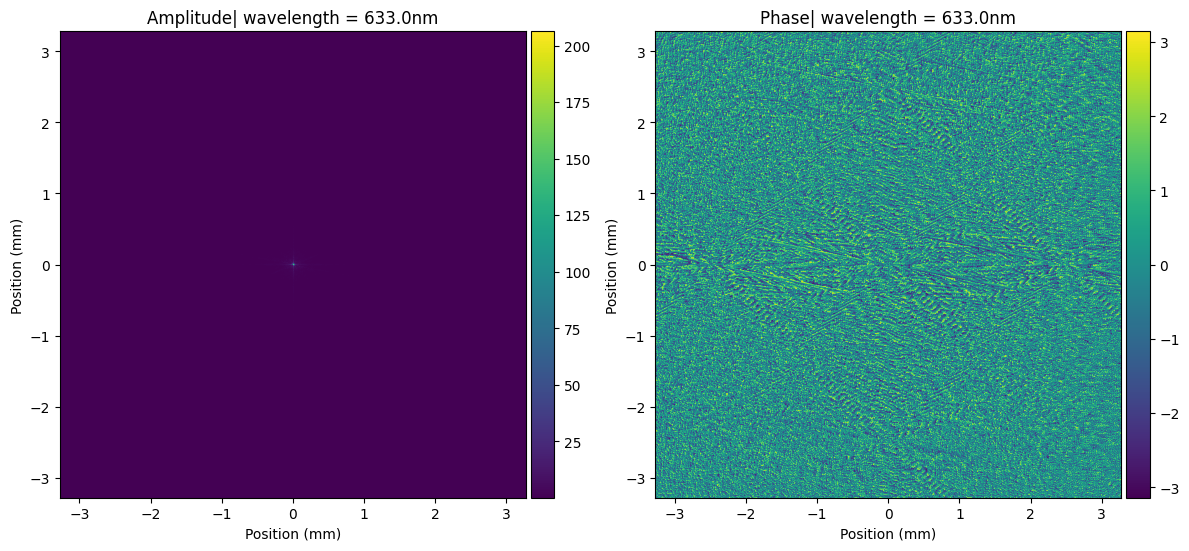

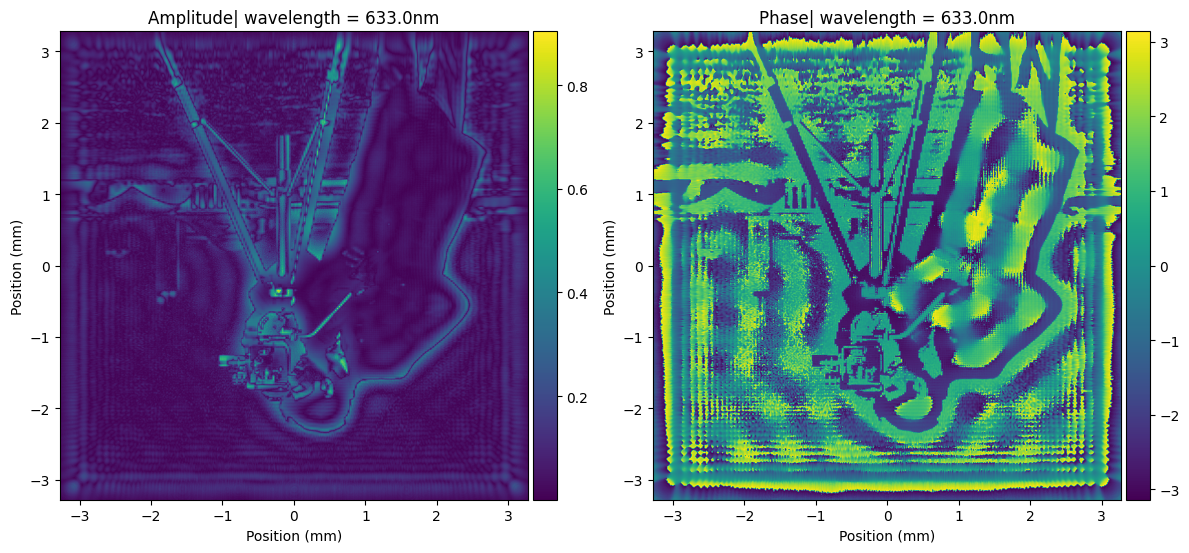

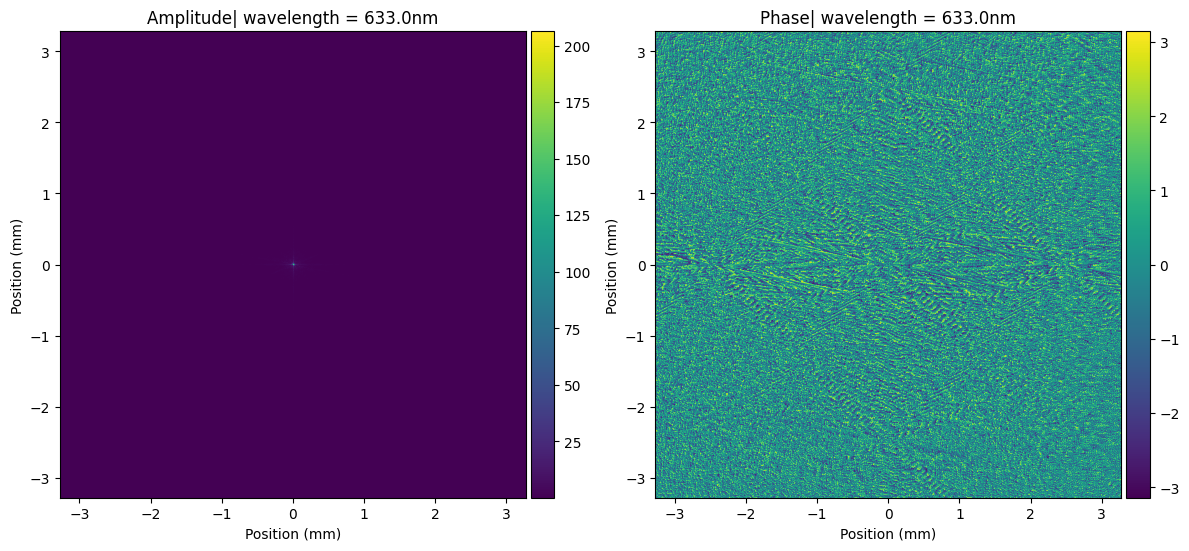

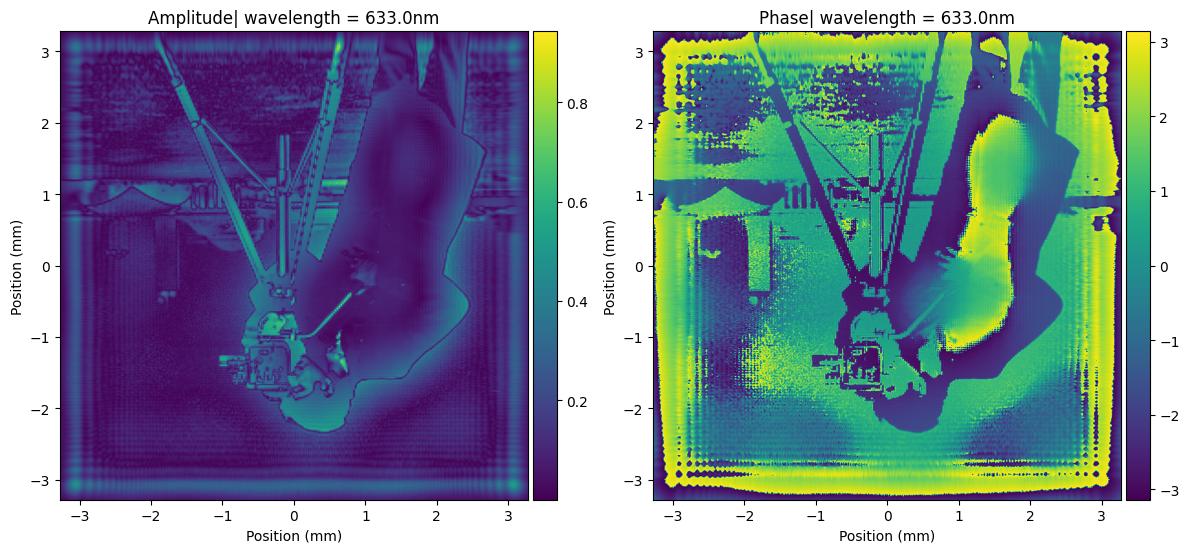

In [14]:
# Create filters for each batch and apply 4F system
filters_list = create_filters(
    height,
    width,
    radius_ratios=[0.10, 0.05, 0.03, 0.01],  # Different radius ratios
    filter_types=['low', 'low', 'high', 'high']  # 2 low-pass, 2 high-pass
)

for freq_filter in filters_list:
    f_filter = freq_filter[None, None, :, :]
    out_field = apply_4F_system(field_input, lens1, lens2, f_filter)
    out_field.visualize(figsize=(12, 12), wavelength=wvl, flag_axis=True, intensity=False)